# 神经网络与微分方程了解

水库入库流量看似简单的问题，在实际生产中由于动库容的存在，传统的静库容方法难以计算出符合实际需要的数据；而动库容的方式目前是基于一些基本定律，偏经验公式的方法，在精度上都不能满足进一步发展的需要。因此水动力方程的应用目前也成为了工程研究的重点。微分方程和神经网络的结合近两年已经成为了研究热点，因此可以了解一些作为常识。

参考：

- [神经网络常微分方程 (Neural ODEs) 解析](https://zhuanlan.zhihu.com/p/77587163)
- [天生一对，硬核微分方程与深度学习的「联姻」之路](https://zhuanlan.zhihu.com/p/66100816)

为什么我们关注常微分方程呢？

首先，快速简要概括一下常微分方程是什么。常微分方程描述了某些由一个变量决定的过程随时间的变化。这个时间的变化通过下面的微分方程来描述。

$$frac{dx}{dt}+x=1$$

通常情况下，如果我们知道了某些初始条件（过程开始的地方），并且我们想了解这个过程将如何变化成某些最终状态，我们才能讨论解这个微分方程。求解函数也被叫做积分曲线（因为我们可以通过对这个方程积分得到方程的解x(t)）

In [20]:
from sympy import dsolve, Eq, symbols, Function

t = symbols('t')
x = symbols('x', cls=Function)
deqn1 = Eq(x(t).diff(t), 1 - x(t))
sol1 = dsolve(deqn1, x(t))

In [21]:
sol1

Eq(x(t), C1*exp(-t) + 1)

C1为常数，可以在给定初始条件时进行确定。如果以恰当的形式给出微分方程，我们可以用解析法进行求解，但通常是采用数值方法求解。最古老和最简单的算法之一是欧拉法:其核心思想是用切线逐步逼近求解函数。

![](image001.png)

https://tutorial.math.lamar.edu/Classes/DE/EulersMethod.aspx

首先一个非常简单的公式，如下:
$$\frac{dy}{dt}=f(t,y), y(t_0)=y_0$$

其在n个时间步长的离散网格上的解是
$$y_{n+1}=y_n+f(t_n,y_n)\cdot (t_{n+1}-t_n)$$

关于微分方程的更多细节，特别是如何用Python编写它们以及它们的解决方法，我建议你去看看[这本书](https://www.springer.com/gp/book/9783319781440)，在化学、物理和工业领域中也有很多这种时间演化过程的例子，均可以用微分方程来描述。此外，对于微分方程与ML模型相关的其他想法，请访问[此资源](https://julialang.org/blog/2019/01/fluxdiffeq)。与此同时，仔细看看欧拉方程，难道它没有让你想起最近的深度学习架构中的任何东西吗?

残差网络是一种微分方程的解吗？
确实是这样的！$y_{n+1} = y_n + f(t_n, y_n)$就是ResNet中的一个残差连接，表示该层的输出$y_{n+1}$是$f(t_n,y_n)$本身的输出和该层的输入$y_n$的总和。t时刻的初始条件为了神经网络的输出等于期望输出：标量值、关于类别的向量或其他任何输出。

In [1]:
!git clone https://github.com/rtqichen/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 631 (delta 0), reused 2 (delta 0), pack-reused 626
Receiving objects: 100% (631/631), 8.15 MiB | 3.24 MiB/s, done.
Resolving deltas: 100% (378/378), done.


In [3]:
!cd torchdiffeq && pip install -e .

Obtaining file:///mnt/d/Code/elks/math-basics/equation/torchdiffeq
  Attempting uninstall: torchdiffeq
    Found existing installation: torchdiffeq 0.1.0
    Uninstalling torchdiffeq-0.1.0:
      Successfully uninstalled torchdiffeq-0.1.0
  Running setup.py develop for torchdiffeq


In [4]:
!ls torchdiffeq/torchdiffeq

__init__.py  __pycache__  _impl


In [5]:
# !wget https://www.dropbox.com/s/wmw93urz7e4mqo5/control_beats_6.npy
# beats = np.load('control_beats_6.npy')

In [7]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from torchdiffeq.torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint

In [8]:
batch_time = 10
batch_size = 20
data_size = 200

viz = True

In [9]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [10]:
DATA_TYPE = 'NNET_MORE'

In [11]:
if viz:
    makedirs(DATA_TYPE)
    import matplotlib.pyplot as plt

def visualize(true_y, pred_y, odefunc, itr):
  
    if viz:
      
        plt.figure()
        plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
        plt.show()
        
        plt.figure()
        plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/phase' + str(itr) + '.png')
        plt.show()

In [12]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [13]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


In [14]:
true_y0 = torch.tensor([[1., 1.]])
t = torch.linspace(-1., 1., data_size)

# true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
# true_A = torch.randn(2, 2)/2.

# a, b, c, d = 1.5, 1.0, 3.0, 1.0
# true_A = torch.tensor([[0., -b*c/d], [d*a/b, 0.]])

# true_A2 = torch.tensor([[-0.1, -0.5], [0.5, -0.1]])
# true_B2 = torch.tensor([[0.2, 1.], [-1, 0.2]])

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)
   
      
class Lambda2(nn.Module):
    
    def __init__(self, A, B):
        super(Lambda2, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
    
    def forward(self, t, y):
        xTx0 = torch.sum(y * true_y0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(y - true_y0) + torch.sigmoid(-xTx0) * self.B(y + true_y0)
        return dxdt
      
# with torch.no_grad():
#     true_y = odeint(Lambda2(true_A2, true_B2), true_y0, t, method='dopri5')
    
# with torch.no_grad():
#     true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [15]:
true_y0 = torch.tensor([[1., 1.]])
t = torch.linspace(-15., 15., data_size)


class Lambda3(nn.Module):
  
    def __init__(self):
        super(Lambda3, self).__init__()
        self.fc1 = nn.Linear(2, 25, bias = False)
        self.fc2 = nn.Linear(25, 50, bias = False)
        self.fc3 = nn.Linear(50, 10, bias = False)
        self.fc4 = nn.Linear(10, 2, bias = False)
        self.relu = nn.ELU(inplace=True)
        
    def forward(self, t, y):
        x = self.relu(self.fc1(y * t))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
     
with torch.no_grad():
    true_y = odeint(Lambda3(), true_y0, t, method='dopri5')

In [16]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


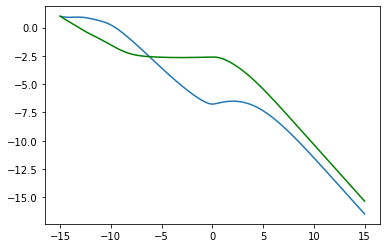

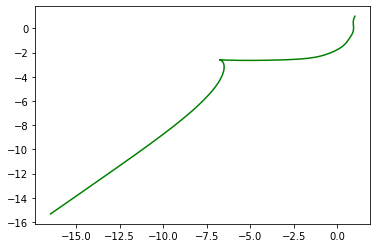

In [17]:
plt.figure()
plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
plt.show()

plt.figure()
plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
plt.show()

Iter 0050 | Total Loss 1.647912


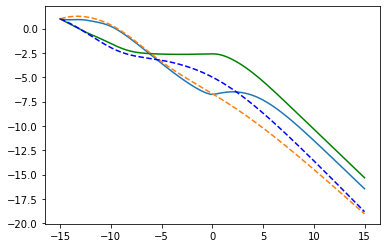

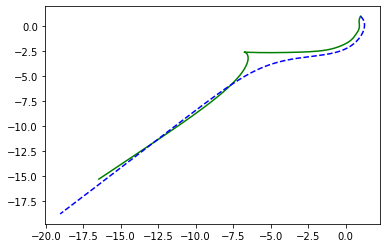

Iter 0100 | Total Loss 5.003569


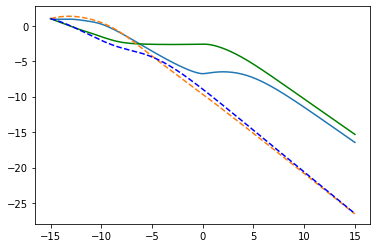

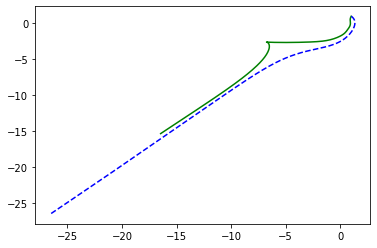

Iter 0150 | Total Loss 1.895716


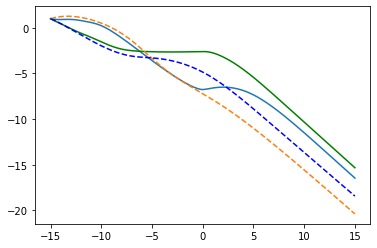

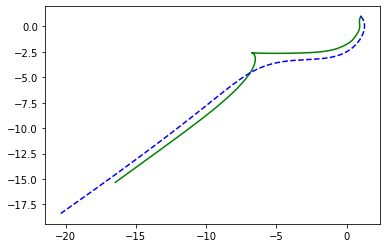

Iter 0200 | Total Loss 3.512843


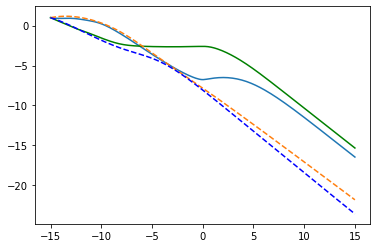

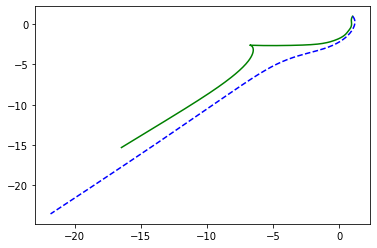

Iter 0250 | Total Loss 1.400941


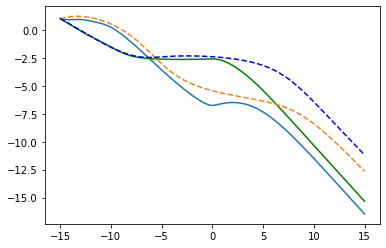

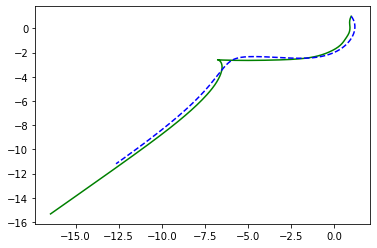

Iter 0300 | Total Loss 3.888628


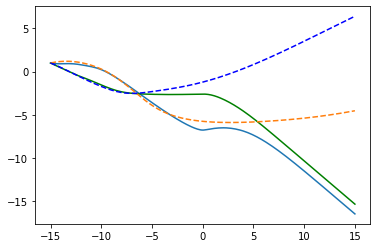

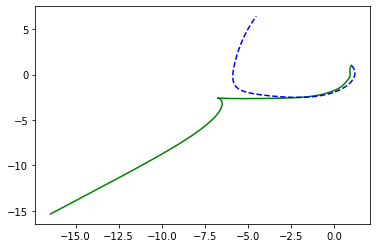

Iter 0350 | Total Loss 4.588518


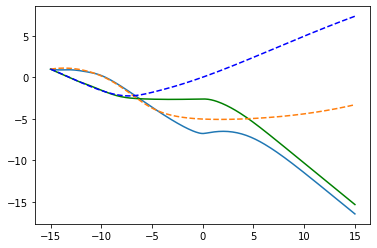

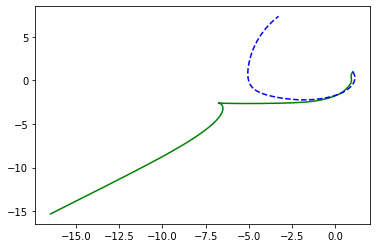

Iter 0400 | Total Loss 0.267384


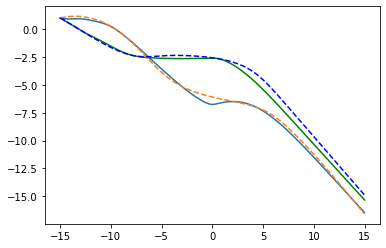

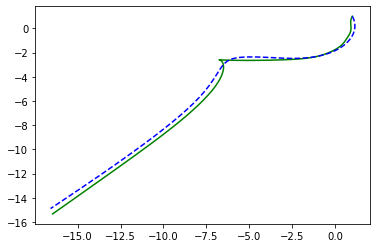

Iter 0450 | Total Loss 2.832527


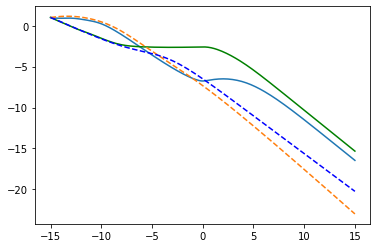

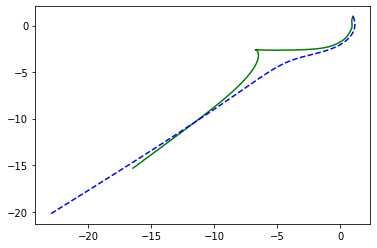

Iter 0500 | Total Loss 3.196252


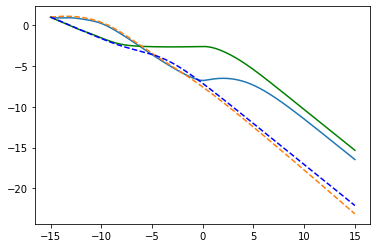

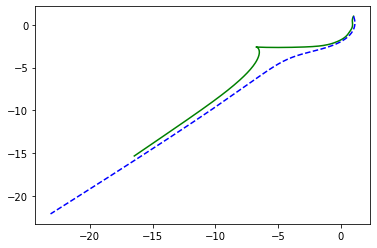

In [18]:
ii = 0
niters = 500

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % 50 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

In [ ]:
# !zip -r /content/VOLTERLOTKA.zip /content/VOLTERLOTKA

In [ ]:
# from google.colab import files

In [ ]:
# files.download("/content/AB.zip")

In [ ]:
# import imageio
# import glob

In [ ]:
# kargs = { 'duration': 0.5 }
# PATH = sorted(glob.glob('/content/VOLTERLOTKA/*.png'))

# images = []
# for filename in PATH:
#     if 'ts' in filename:
#       images.append(imageio.imread(filename))
# imageio.mimsave('/content/VOLTERLOTKA/movie_ts.gif', images, **kargs)

# images = []
# for filename in PATH:
#     if 'phase' in filename:
#       images.append(imageio.imread(filename))
# imageio.mimsave('/content/VOLTERLOTKA/movie_phase.gif', images, **kargs)